In [156]:
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import jax
import matplotlib.pyplot as plt

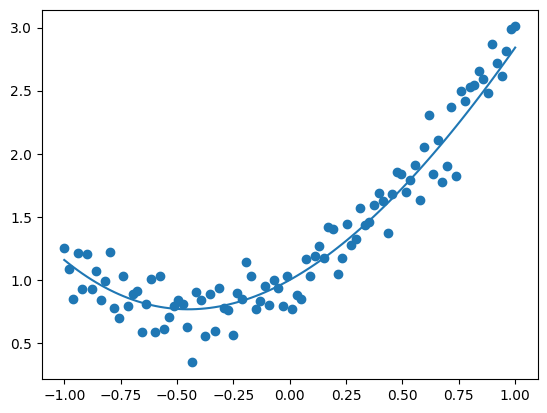

In [157]:
x_lin = torch.linspace(-1, 1, 100)  
x_axis = x_lin.numpy()
f = lambda x: x**2 + torch.sin(x) + 1
eps = torch.randn(100) * 0.2
y = f(x_lin) + eps

y = y.unsqueeze(-1)

plt.plot(x_lin, f(x_lin))
plt.scatter(x_lin, y)

In [158]:
# Add a column of ones to x_lin
x_lin = torch.stack([ torch.ones(100), x_lin], dim=1)

# Add a column of x^2 to x_lin
x_lin = torch.cat([x_lin, x_lin[:,1].unsqueeze(1)**2], dim=1)

# Add a column of x^3 to x_lin
x_lin = torch.cat([x_lin, x_lin[:,1].unsqueeze(1)**3], dim=1)

# Add a column of x^4 to x_lin
x_lin = torch.cat([x_lin, x_lin[:,1].unsqueeze(1)**4], dim=1)

In [159]:
sli = 0.2

In [169]:
import hamiltorch

def nn_forward(x , w):

    model = torch.nn.Sequential(
        torch.nn.Linear(5, 2),
        torch.nn.ReLU(),
        torch.nn.Linear(2, 1),
    )

    # param = {"params" : w}
    # y_pred = torch.func.functional_call(model, param , x)

    params_list = hamiltorch.util.unflatten(model, w)
    hamiltorch.util.update_model_params_in_place(model, params_list)
    y_pred = model(x)

    return y_pred

In [170]:
def pyro_model(x,y):
    w = pyro.sample("w", dist.Normal(0, 1).expand([15]).to_event(1))
    mean = nn_forward(x, w)
    with pyro.plate("data", x.shape[0]):
        y_pred = pyro.sample("obs", dist.Normal(mean, sli), obs=y)
    return y_pred

In [171]:
nuts_kernel = NUTS(pyro_model)
mcmc = MCMC(nuts_kernel, num_samples=100 , warmup_steps=20)
mcmc.run(x_lin, y)

Sample: 100%|██████████| 120/120 [04:05,  2.04s/it, step size=2.42e-03, acc. prob=0.264]


In [172]:
samples_ = mcmc.get_samples()
samples_

{'w': tensor([[-0.7406, -1.4753,  0.7182,  ...,  0.1818,  0.3084,  0.8250],
         [-0.7437, -1.4784,  0.7170,  ...,  0.1789,  0.3118,  0.8285],
         [-0.7418, -1.4966,  0.7110,  ...,  0.1359,  0.3424,  0.8339],
         ...,
         [-0.7102, -1.6939,  0.7393,  ...,  0.2987,  0.5915,  0.4446],
         [-0.7137, -1.6937,  0.7405,  ...,  0.2989,  0.5932,  0.4459],
         [-0.7137, -1.6939,  0.7406,  ...,  0.2987,  0.5929,  0.4458]])}

In [173]:
w_mean = samples_['w'].mean(axis=0)
w_mean

tensor([-0.7464, -1.6037,  0.7238, -1.8694, -0.9699,  0.5980,  1.5562,  0.4258,
         0.7933,  0.8903, -0.1421,  0.4735,  0.2526,  0.5324,  0.5386])

In [174]:
model = torch.nn.Sequential(
    torch.nn.Linear(5, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
)

# Number of parameters in the model
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % n_params)

Number of parameters: 15


In [175]:
# Run the model on the data

params_list = hamiltorch.util.unflatten(model, w_mean)
hamiltorch.util.update_model_params_in_place(model, params_list)
y_pred = model(x_lin)

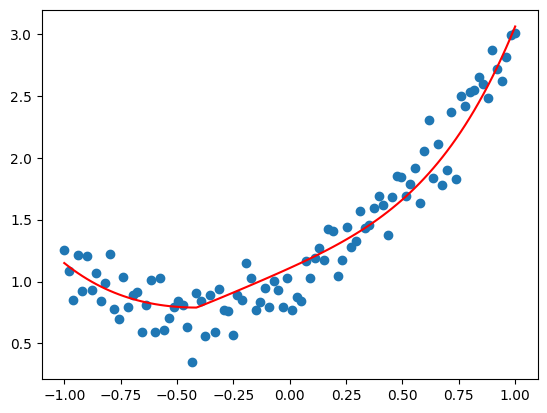

In [176]:
x_axis = x_lin[:,1]
plt.plot(x_axis, y_pred.detach().numpy() , color='red')
plt.scatter(x_axis, y)
plt.show()